# הקדמה: הגדרת סביבת העבודה וייבוא ספריות
בשלב זה אנו מכינים את סביבת העבודה לפרויקט כריית הטקסטים.
הפעולות המתבצעות:
1.  **התקנת חבילות חיצוניות:** התקנת ספריית `transformers` של Hugging Face המאפשרת עבודה עם מודלי שפה מתקדמים (כמו BERT), וספריות עזר נוספות.
2.  **ייבוא ספריות:**
    * `Pandas`, `NumPy`: לעיבוד וניתוח טבלאי של הנתונים.
    * `PyTorch` / `TensorFlow`: ספריות למידה עמוקה (נשתמש ב-PyTorch עבור מודל ה-HeBERT).
    * `Sklearn`: למימוש אלגוריתמים קלאסיים (כמו K-Means) ומדדי הערכה.
    * `Matplotlib`, `Seaborn`: לוויזואליזציה והצגת גרפים.
3.  **בדיקת חומרה:** וידוא שהסביבה מחוברת ל-GPU (כרטיס מסך) כדי להאיץ את חישובי המודלים הכבדים.

In [1]:
# ==========================================
# 1. התקנות (Quiet install)
# ==========================================
!pip install transformers datasets evaluate accelerate -q

# ==========================================
# 2. ייבוא ספריות בסיס וטיפול בנתונים
# ==========================================
import pandas as pd
import numpy as np
import re
import ast
import torch
from google.colab import drive
from collections import Counter

# ==========================================
# 3. ויזואליזציה (EDA)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ==========================================
# 4. Scikit-Learn (Classical ML & Preprocessing)
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# ==========================================
# 5. Deep Learning (TensorFlow & Keras)
# ==========================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GlobalMaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# ==========================================
# 6. Transformers (State-of-the-Art NLP)
# ==========================================
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset

# הגדרת מכשיר (GPU אם זמין)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#print(f"Using device: {device}")
print("All libraries imported and ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
All libraries imported and ready.


# שלב א': טעינת נתונים, סינון וניתוח ראשוני (EDA)
בהתאם לדרישות הפרויקט לאיסוף וניקוי נתונים, בחלק זה אנו מבצעים:
1.  **טעינת הנתונים:** קריאת קובץ ה-Dataset (`music.csv`) המכיל את מילות השירים ושמות האמנים.
2.  **ניקוי ראשוני:** הסרת רשומות כפולות ומחיקת שורות חסרות (Missing Values) כדי להבטיח את איכות המידע.
3.  **סינון אמנים:** אנו משאירים רק אמנים שיש להם מעל 15 שירים. המטרה היא ליצור פרופיל אמן יציב ומייצג; אמנים עם מעט שירים עלולים להוביל להטיות במודל.
4.  **ויזואליזציה:** הצגה גרפית של כמות השירים לאמן כדי להבין את התפלגות הנתונים.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Columns found in CSV: ['artist', 'songs', 'song', 'artist_key', 'words count', 'unique words count']
Number of artists with at least 15 songs: 151
Total songs for analysis: 12409


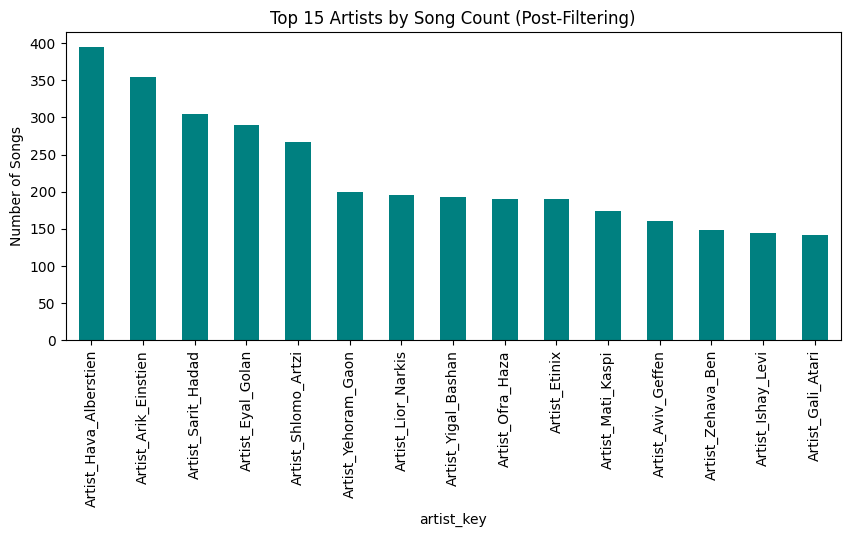

In [24]:
# 1. טעינת הקובץ

drive.mount('/content/gdrive')


data_path =  '/content/gdrive/MyDrive/Colab Notebooks/DM project/'
PATH = data_path + 'music.csv'
df_raw = pd.read_csv(PATH,encoding='utf-8')
# בדיקה מהירה: הדפסת שמות העמודות כדי לוודא
print("Columns found in CSV:", df_raw.columns.tolist())

# הגדרת שם עמודת הטקסט (נראה שזה 'songs' אצלך)
TEXT_COL = 'songs'
ARTIST_COL = 'artist_key'

# 2. ניקוי בסיסי
# שימוש בשמות המשתנים כדי למנוע שגיאות
df = df_raw.drop_duplicates(subset=[TEXT_COL]).dropna(subset=[TEXT_COL, ARTIST_COL]).copy()

# 3. סינון אמנים לפי סף מינימום של שירים
MIN_SONGS_PER_ARTIST = 15
artist_counts = df[ARTIST_COL].value_counts()
valid_artists = artist_counts[artist_counts >= MIN_SONGS_PER_ARTIST].index

df = df[df[ARTIST_COL].isin(valid_artists)].reset_index(drop=True)

# 4. EDA מהיר
print(f"Number of artists with at least {MIN_SONGS_PER_ARTIST} songs: {len(valid_artists)}")
print(f"Total songs for analysis: {len(df)}")

plt.figure(figsize=(10, 4))
df[ARTIST_COL].value_counts().head(15).plot(kind='bar', color='teal')
plt.title('Top 15 Artists by Song Count (Post-Filtering)')
plt.ylabel('Number of Songs')
plt.show()

# עיבוד מקדים של הטקסט (Text Preprocessing)
לפני הזנת הטקסטים למודל, עלינו לנקות ולנרמל אותם.
פונקציית הניקוי מבצעת:
* **הסרת רעשים:** ניקוי תווים שאינם אותיות בעברית או רווחים (כגון סימני פיסוק מורכבים או תווים בשפות זרות), אשר עלולים לבלבל את המודל.
* **תיקון היפוך (במידת הצורך):** מנגנון לתיקון טקסט עברי שהתהפך (Visual/Logical Hebrew order).
* **ניקול רווחים:** הסרת רווחים כפולים ומיותרים.

תהליך זה חיוני כדי שמודל ה-BERT יוכל להתמקד בתוכן הסמנטי של השיר ללא הפרעות.

In [25]:
# ==========================================
# פונקציית בדיקה - האם הטקסט הפוך?
# ==========================================
sample_song = df[TEXT_COL].iloc[0]
print("--- שיר מקורי (דוגמה) ---")
print(sample_song[:100]) # מדפיס 100 תווים ראשונים

# אם הטקסט נראה כמו "םולש", נשנה את המשתנה הזה ל-True
REVERSE_HEBREW_NEEDED = False

# ==========================================
# פונקציות ניקוי
# ==========================================
def clean_and_fix_text(text, needs_reversing=False):
    if not isinstance(text, str): return ""

    # 1. תיקון היפוך אם צריך (ברמת המילה או המשפט)
    if needs_reversing:
        # אופציה א: היפוך כל המחרוזת
        # text = text[::-1]
        # אופציה ב: היפוך כל מילה בנפרד (כפי שציינת)
        words = text.split()
        text = " ".join([w[::-1] for w in words])

    # 2. ניקוי רעש בסיסי (משאירים עברית, רווחים וסימני פיסוק בסיסיים)
    # למודלים מתקדמים כמו BERT עדיף לא למחוק הכל, אבל ל-ML קלאסי זה עוזר.
    # כאן נשמור על עברית ורווחים בלבד.
    text = re.sub(r'[^\u0590-\u05fe\s]', '', text)

    # 3. הסרת רווחים כפולים
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# החלה ראשונית ללא היפוך כדי לראות מה המצב
# אם תראה בפלט שהעברית הפוכה, שנה את REVERSE_HEBREW_NEEDED ל-True והרץ שוב
df['clean_text'] = df[TEXT_COL].apply(lambda x: clean_and_fix_text(x, needs_reversing=REVERSE_HEBREW_NEEDED))

print("\n--- שיר לאחר ניקוי ---")
print(df['clean_text'].iloc[0][:100])

--- שיר מקורי (דוגמה) ---
['כשאת', 'רקיע', 'השמיים', 'ציירתי', 'בצבעו', 'הכחול', 'זכרתי', 'נוף', 'ילדות', 'שדות', 'יחפים', 'צי

--- שיר לאחר ניקוי ---
כשאת רקיע השמיים ציירתי בצבעו הכחול זכרתי נוף ילדות שדות יחפים ציור מכחול בלילות כשירח מחייך הטיל את


# שלב ב': ייצוג טקסטואלי (Embedding) באמצעות HeBERT
בשלב זה אנו ממירים את הטקסט החופשי (מילות השירים) לייצוג וקטורי מספרי (Embeddings).
אנו משתמשים במודל **`avichr/heBERT`**, מודל שפה מבוסס Transformer שאומן ספציפית על טקסטים בעברית.

**תהליך העבודה:**
1.  **Tokenization:** פירוק הטקסט לתת-יחידות (Tokens) שהמודל מכיר.
2.  **הרצת המודל:** הזנת השירים למודל וקבלת הפלט מהשכבה הנסתרת האחרונה.
3.  **שליפת וקטור ה-[CLS]:** אנו משתמשים בווקטור המייצג את הטוקן הראשון (`[CLS]`), אשר נהוג להשתמש בו כמייצג את המשמעות הסמנטית של הטקסט כולו (בגודל 768 מימדים).

התוצאה היא עמודה חדשה בדאטה-פריים המכילה וקטור מספרי לכל שיר, המייצג את תוכנו.

In [26]:
import torch # ליתר ביטחון

# 1. הגדרת ההתקן (GPU) - חובה כדי ש-PyTorch ישתמש ב-T4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device: {device}") # צריך להדפיס 'cuda'

# ==========================================
# טעינת המודל וה-Tokenizer של HeBERT
# ==========================================
print("Loading HeBERT model...")
model_name = "avichr/heBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ==========================================
# פונקציה ליצירת Embeddings ב-Batches
# ==========================================
def get_embeddings(text_list, batch_size=32):
    model.eval() # מצב אימון כבוי (חוסך זיכרון)
    all_embeddings = []

    # עיבוד בחבילות כדי לא להעמיס על הזיכרון
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i + batch_size]

        # Tokenization
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        # הרצת המודל
        with torch.no_grad():
            outputs = model(**inputs)

        # לקיחת ה-CLS Token
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(embeddings)

        if i % 2000 == 0:
            print(f"Processed {i}/{len(text_list)} songs...")

    return np.array(all_embeddings)

# ==========================================
# הפעלה על כל השירים
# ==========================================
print("Generating embeddings for all songs...")
texts = df['clean_text'].tolist()

# יצירת הוקטורים
embeddings_matrix = get_embeddings(texts, batch_size=32)

# שמירה ב-DataFrame
df['embedding'] = list(embeddings_matrix)

print("Done!")
print(f"Embedding shape for one song: {df['embedding'].iloc[0].shape}")

Working on device: cuda
Loading HeBERT model...


Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating embeddings for all songs...
Processed 0/12409 songs...
Processed 4000/12409 songs...
Processed 8000/12409 songs...
Processed 12000/12409 songs...
Done!
Embedding shape for one song: (768,)


# חלוקת הנתונים ויצירת פרופיל אמן (Artist Profiling)
כדי לאפשר הערכה אמינה של המודלים בהמשך, אנו מחלקים את הנתונים לקבוצות:
* **Train (70%):** לאימון ובניית הפרופילים.
* **Validation (15%):** לכיוונון פרמטרים.
* **Test (15%):** לבדיקה סופית.

**יצירת פרופיל אמן (Artist Embedding):**
מכיוון שהמטרה שלנו היא לנתח אמנים (ולא שירים בודדים), אנו יוצרים וקטור מייצג לכל אמן.
הווקטור של האמן מחושב כ**ממוצע (Mean)** של כל וקטורי השירים שלו (מתוך קבוצת האימון בלבד). הנחה זו מתבססת על כך שסגנון האמן משתקף בממוצע הסמנטי של יצירותיו.

In [27]:
from sklearn.model_selection import train_test_split
import numpy as np

# ==========================================
# 1. חלוקה מדויקת: Train (70%), Val (15%), Test (15%)
# ==========================================
print("Splitting data into Train, Validation, and Test...")

# שלב א': הפרשת ה-Test (15% מהכל)
# נשארנו עם 85% ל-Train+Validation
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df[ARTIST_COL], # שומר על ייצוג הוגן לכל אמן
    random_state=42
)

# שלב ב': חלוקת היתרה ל-Train ו-Validation
# אנחנו צריכים שה-Validation יהיה 15% מהסך הכללי.
# כרגע יש לנו 85%. החישוב היחסי: 0.15 / 0.85 = 0.17647...
relative_val_size = 0.15 / 0.85

train_df, val_df = train_test_split(
    train_val_df,
    test_size=relative_val_size,
    stratify=train_val_df[ARTIST_COL],
    random_state=42
)

# ==========================================
# 2. בדיקת תקינות (Sanity Check)
# ==========================================
total = len(df)
print(f"🔹 Train Set:      {len(train_df)} songs ({len(train_df)/total:.1%})")
print(f"🔹 Validation Set: {len(val_df)} songs ({len(val_df)/total:.1%})")
print(f"🔹 Test Set:       {len(test_df)} songs ({len(test_df)/total:.1%})")

# ==========================================
# 3. חישוב פרופיל אמן (על בסיס Train בלבד!)
# ==========================================
print("\nCalculating artist profiles based on Train data only...")

# פונקציה לחישוב ממוצע וקטורי
def mean_embedding(embedding_series):
    return np.mean(np.vstack(embedding_series), axis=0)

# קיבוץ לפי אמן וחישוב הממוצע
artist_profiles = train_df.groupby(ARTIST_COL)['embedding'].apply(mean_embedding).reset_index()

# המרה למטריצה לצורך האלגוריתם (K-Means)
artist_matrix = np.vstack(artist_profiles['embedding'].values)

print(f"✅ Created profiles for {len(artist_matrix)} artists based on training data.")

Splitting data into Train, Validation, and Test...
🔹 Train Set:      8685 songs (70.0%)
🔹 Validation Set: 1862 songs (15.0%)
🔹 Test Set:       1862 songs (15.0%)

Calculating artist profiles based on Train data only...
✅ Created profiles for 151 artists based on training data.


In [28]:
# המרה למטריצה לצורך האלגוריתם
artist_matrix = np.vstack(artist_profiles['embedding'].values)

# שלב ג': ניתוח אשכולות (Clustering) - מציאת קבוצות אמנים
בשלב זה אנו מפעילים אלגוריתם למידה בלתי-מפוקחת (Unsupervised Learning) מסוג **K-Means** על וקטורי האמנים. המטרה היא לגלות קבוצות של אמנים בעלי סגנון טקסטואלי דומה, ללא ידע מוקדם.

**אופטימיזציה של מספר האשכולות (K):**
מכיוון שאיננו יודעים מראש כמה "סגנונות" קיימים, אנו בוחנים טווח של ערכי K (בין 4 ל-15) ומשתמשים בשתי שיטות להערכת הביצועים:
1.  **שיטת המרפק (Elbow Method):** בדיקת מדד ה-Inertia (סכום מרחקי הנקודות ממרכז האשכול). נחפש את הנקודה שבה הירידה בשגיאה מתמתנת.
2.  **מדד הצללית (Silhouette Score):** בודק עד כמה כל אמן קרוב לחברי האשכול שלו לעומת אשכולות אחרים. ציון גבוה יותר מעיד על חלוקה טובה יותר.

הגרפים שיוצגו יעזרו לנו לבחור את ה-K האופטימלי להמשך הניתוח.

Calculating artist profiles based on Training Data...
Analyzing 151 artists.
Running clustering analysis...


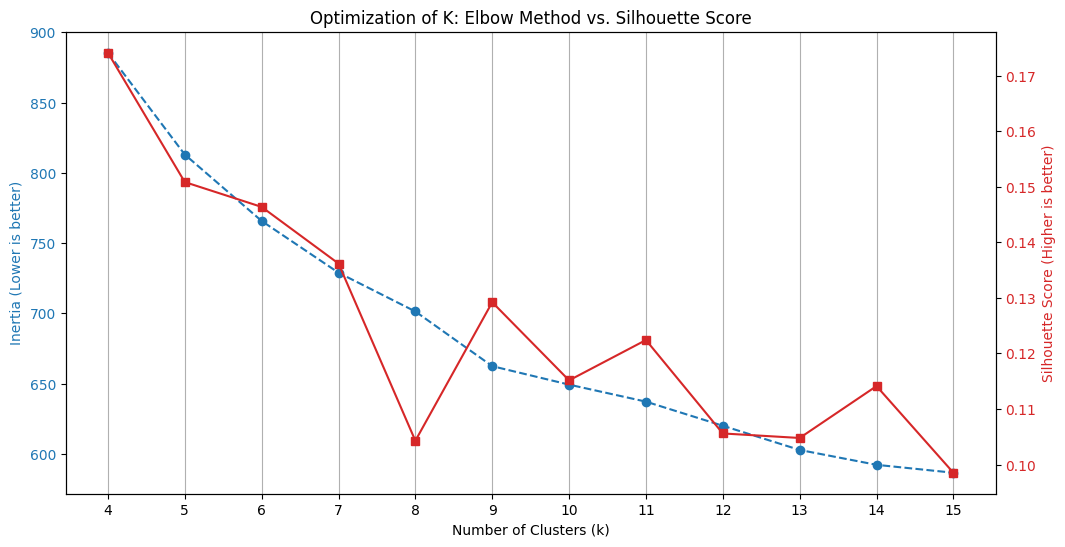

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np


# וודא שביצעת את ה-train_test_split מהבלוקים הקודמים
if 'train_df' not in locals():
    print("Please run the train_test_split block first!")
else:
    # פונקציה לחישוב ממוצע
    def mean_embedding(embedding_series):
        return np.mean(np.vstack(embedding_series), axis=0)

    # יצירת מטריצת האמנים (רק על סמך ה-Train!)
    print("Calculating artist profiles based on Training Data...")
    artist_profiles = train_df.groupby(ARTIST_COL)['embedding'].apply(mean_embedding).reset_index()
    artist_matrix = np.vstack(artist_profiles['embedding'].values)
    print(f"Analyzing {len(artist_matrix)} artists.")

    # ==========================================
    # 2. לולאת בדיקה (K בין 4 ל-15)
    # ==========================================
    inertias = []
    silhouettes = []
    k_range = range(4, 16) # בודקים מ-4 עד 15 קבוצות

    print("Running clustering analysis...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(artist_matrix)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(artist_matrix, kmeans.labels_))

    # ==========================================
    # 3. הצגת הגרפים
    # ==========================================
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # גרף 1: Elbow (המרפק) - שואפים למקום שבו הירידה מתמתנת
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia (Lower is better)', color=color)
    ax1.plot(k_range, inertias, 'o--', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='x')

    # גרף 2: Silhouette (צללית) - שואפים לגבוה ביותר
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score (Higher is better)', color=color)
    ax2.plot(k_range, silhouettes, 's-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Optimization of K: Elbow Method vs. Silhouette Score')
    plt.xticks(k_range)
    plt.show()

Clustering artists into 9 style groups...


/tmp/ipython-input-2936176091.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', CHOSEN_K)


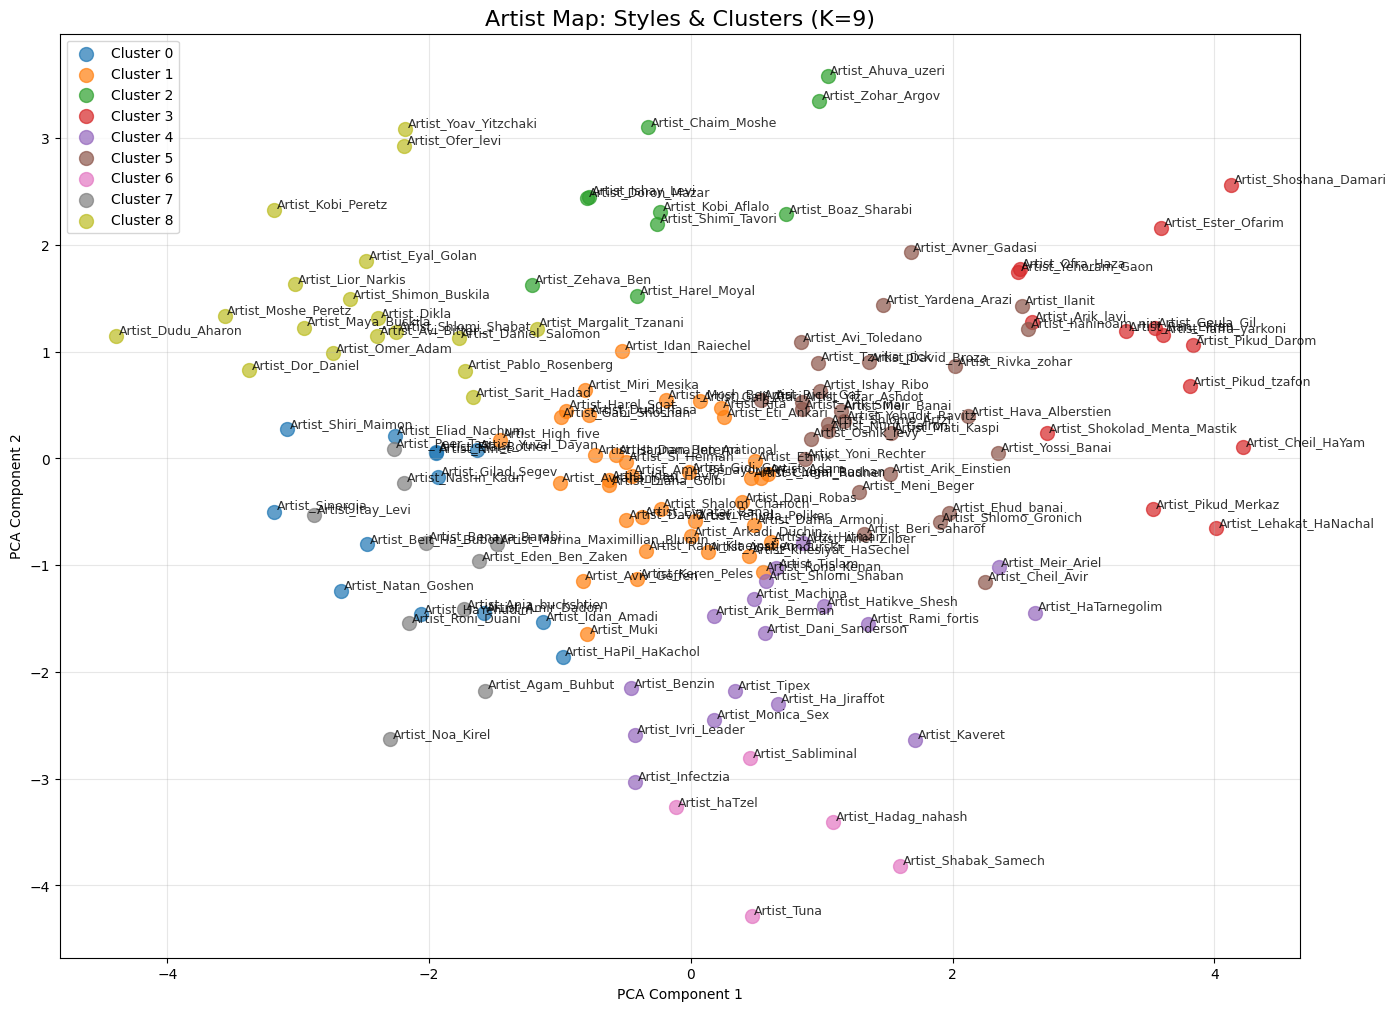


--- חלוקת האמנים לקבוצות ---

🟦 Cluster 0 (13 artists):

🟦 Cluster 1 (37 artists):

🟦 Cluster 2 (10 artists):

🟦 Cluster 3 (14 artists):

🟦 Cluster 4 (17 artists):

🟦 Cluster 5 (27 artists):

🟦 Cluster 6 (5 artists):

🟦 Cluster 7 (10 artists):

🟦 Cluster 8 (18 artists):


In [32]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# ==========================================
# 1. הגדרת מספר הקבוצות הנבחר (נא לשנות לפי הגרף הקודם!)
# ==========================================
CHOSEN_K = 9  # <--- שנה את המספר הזה לפי נקודת ה"מרפק" או ה-Silhouette הגבוה

# ==========================================
# 2. ביצוע האשכול הסופי
# ==========================================
print(f"Clustering artists into {CHOSEN_K} style groups...")
kmeans_final = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(artist_matrix)

# שמירת התוצאות ב-DataFrame של הפרופילים
artist_profiles['cluster'] = cluster_labels
artist_to_cluster_map = dict(zip(artist_profiles[ARTIST_COL], artist_profiles['cluster']))

# ==========================================
# 3. הפחתת מימדים ל-2D לצורך גרף XY
# ==========================================
pca = PCA(n_components=2)
reduced_artists = pca.fit_transform(artist_matrix)

# הוספת הקואורדינטות ל-DataFrame לנוחות
artist_profiles['x'] = reduced_artists[:, 0]
artist_profiles['y'] = reduced_artists[:, 1]

# ==========================================
# 4. ציור הגרף (XY Scatter Plot)
# ==========================================
plt.figure(figsize=(16, 12))

# יצירת סקאלת צבעים
colors = plt.cm.get_cmap('tab10', CHOSEN_K)

# ציור הנקודות
for i in range(CHOSEN_K):
    cluster_data = artist_profiles[artist_profiles['cluster'] == i]
    plt.scatter(cluster_data['x'], cluster_data['y'],
                s=100, label=f'Cluster {i}', alpha=0.7)

# הוספת שמות האמנים (ללא היפוך)
for _, row in artist_profiles.iterrows():
    name_display = row[ARTIST_COL] # תצוגה רגילה
    plt.text(row['x'] + 0.02, row['y'] + 0.02, name_display, fontsize=9, alpha=0.8)

plt.title(f'Artist Map: Styles & Clusters (K={CHOSEN_K})', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 5. הדפסת רשימת האמנים בכל קבוצה
# ==========================================
print("\n--- חלוקת האמנים לקבוצות ---")
for i in range(CHOSEN_K):
    artists_in_cluster = artist_profiles[artist_profiles['cluster'] == i][ARTIST_COL].tolist()
    print(f"\n🟦 Cluster {i} ({len(artists_in_cluster)} artists):")
    # מדפיס את כל האמנים בקבוצה כדי שתוכל לבח

In [33]:
# הדפסה מסודרת של האמנים בכל קבוצה
print(f"\n--- חלוקת האמנים ל-{CHOSEN_K} קבוצות ---")

for i in range(CHOSEN_K):
    # שליפת רשימת האמנים בקבוצה הנוכחית
    artists_in_cluster = artist_profiles[artist_profiles['cluster'] == i][ARTIST_COL].tolist()

    # הדפסת הכותרת (מספר הקבוצה וכמות האמנים בה)
    print(f"\n🟦 קבוצה {i} ({len(artists_in_cluster)} אמנים):")

    # הדפסת שמות האמנים מופרדים בפסיקים
    print(", ".join(artists_in_cluster))


--- חלוקת האמנים ל-9 קבוצות ---

🟦 קבוצה 0 (13 אמנים):
Artist_Amir_Dadon, Artist_Beit_Ha_Bubot, Artist_Elai_Botner, Artist_Eliad_Nachum, Artist_Gilad_Segev, Artist_HaPil_HaKachol, Artist_HaYehudim, Artist_Idan_Amadi, Artist_Natan_Goshen, Artist_Ninet, Artist_Shiri_Maimon, Artist_Sinergia, Artist_Yuval_Dayan

🟦 קבוצה 1 (37 אמנים):
Artist_Adam, Artist_Amir_Benayoun, Artist_Arkadi_Duchin, Artist_Asaf_Amdurski, Artist_Aviv_Geffen, Artist_Avraham_tal, Artist_Chemi_Rudner, Artist_Dafna_Armoni, Artist_Dana_International, Artist_Dani_Robas, Artist_David_Levi, Artist_Diana_Golbi, Artist_Dudu_Tasa, Artist_Eti_Ankari, Artist_Etinix, Artist_Evyatar_Banai, Artist_Gabi_Shoshan, Artist_Gali_Atari, Artist_Gidi_Gov, Artist_Hannan_Ben_Ari, Artist_Harel_Sqat, Artist_High_five, Artist_Idan_Haviv, Artist_Idan_Raiechel, Artist_Keren_Peles, Artist_Knesiyat_HaSechel, Artist_Miri_Mesika, Artist_Mosh_Ben_Ari, Artist_Muki, Artist_Rami_Klaeinstien, Artist_Rita, Artist_Rona_Kenan, Artist_Shalom_Chanoch, Artist_Si

In [34]:
# 1. התקנת ספריות לעיצוב טקסט בעברית
!pip install wordcloud python-bidi --quiet

# 2. הורדת פונט עברי (Rubik) כדי שענני המילים ייראו טוב
!wget -q https://github.com/google/fonts/raw/main/ofl/rubik/Rubik-Bold.ttf -O /content/Rubik-Bold.ttf

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from bidi.algorithm import get_display # לסידור עברית מימין לשמאל
from collections import Counter

# פונקציית עזר להצגת עברית בגרפים
def visual_hebrew(text):
    return get_display(text)

print("Libraries installed and Hebrew font downloaded.")

Libraries installed and Hebrew font downloaded.


✅ Font downloaded successfully!
✅ Main dataframe updated with cluster labels.
Generating global statistics...


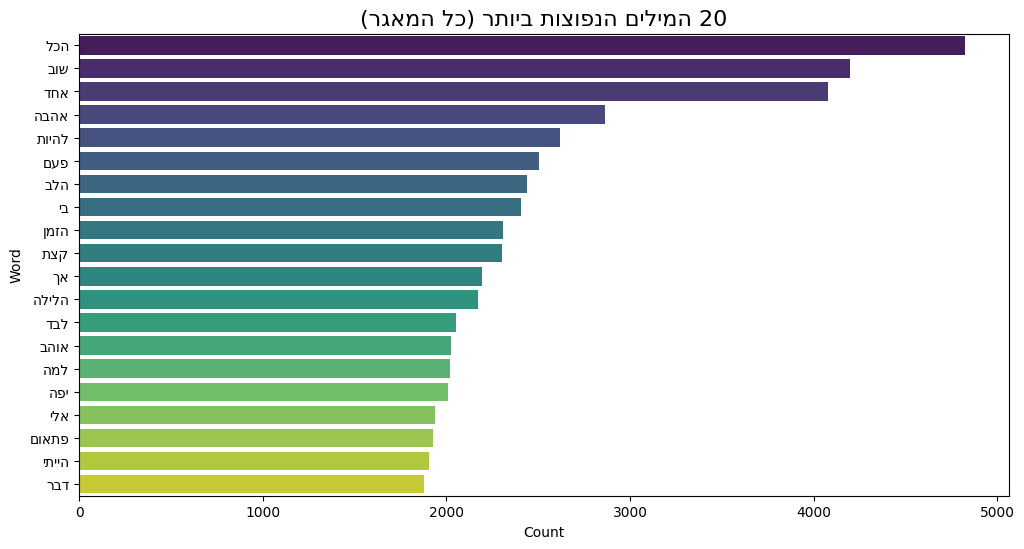

Generating Word Clouds...


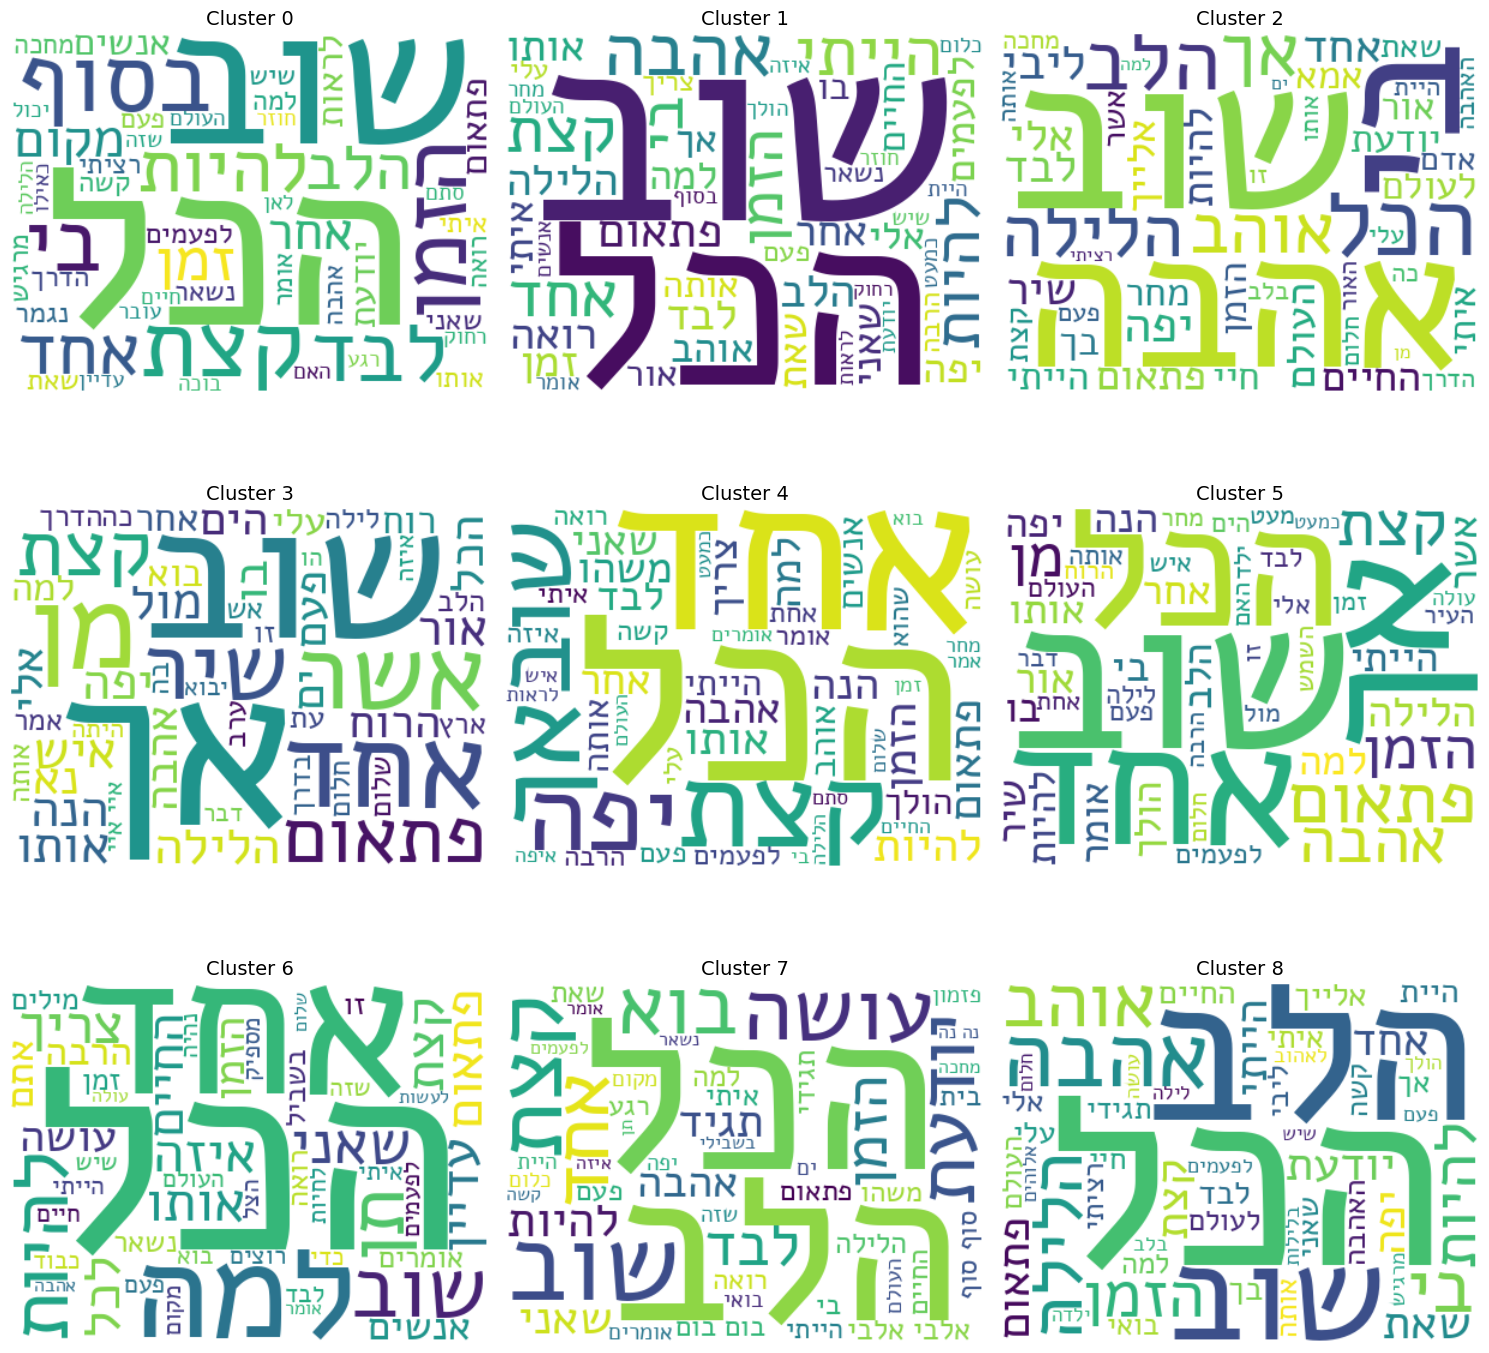


--- מילים מובילות בכל קבוצה ---
Cluster 0: הכל, שוב, אחד, הזמן, להיות, קצת, בסוף, לבד, בי, מקום, הלב, פעם, שאת, נגמר, יכול, אחר, דבר, שאני, אף, זמן, נשאר, יודעת, לראות, מחכה, רגע, לפעמים, הדרך, אותו, לאן, פתאום
Cluster 1: הכל, שוב, אחד, להיות, אהבה, פעם, הזמן, הייתי, בי, אוהב, קצת, הלילה, לבד, הלב, אף, אלי, למה, יכול, אחר, דבר, זמן, פתאום, שאני, אותו, העולם, מקום, יפה, הולך, שאת, הרבה
Cluster 2: שוב, אהבה, הכל, הלב, בי, אלי, שיר, הלילה, אחד, אך, בואי, אמא, אוהב, חיי, יפה, ליבי, בך, למה, לבד, אור, פעם, אדם, העולם, להיות, בוא, פתאום, הזמן, החיים, לילה, איתי
Cluster 3: אך, שוב, אחד, מן, שיר, ים, הו, אשר, שלום, הלילה, הכל, בוא, יפה, אור, נא, קצת, למה, רוח, לילה, בי, הרוח, הנה, בו, אלי, אהבה, תן, פתאום, הים, מול, איש
Cluster 4: אחד, הכל, להיות, פעם, קצת, איזה, יפה, אך, לבד, שוב, דבר, למה, הנה, אותו, שאני, העולם, אותה, הזמן, אחר, אהבה, עלי, הו, הרבה, שהוא, פתאום, הייתי, צריך, אף, מקום, אנשים
Cluster 5: שוב, אחד, הכל, אך, שיר, פעם, אהבה, פתאום, מן, הזמן, דבר, אור, קצת, הלילה, בי, להיות, אחת,

In [37]:
# ==========================================
# 0. התקנות מקדימות (חובה ל-bidi)
# ==========================================
!pip install python-bidi --quiet

import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from bidi.algorithm import get_display
from collections import Counter
import pandas as pd

# ==========================================
# 1. הורדת פונט עברי תקין (Alef)
# ==========================================
font_path = '/content/Alef-Regular.ttf'

if os.path.exists(font_path):
    os.remove(font_path)

print("Downloading Alef font for Hebrew support...")
!wget -q -O /content/Alef-Regular.ttf "https://github.com/google/fonts/raw/main/ofl/alef/Alef-Regular.ttf"

if not os.path.exists(font_path) or os.path.getsize(font_path) < 1000:
    print("❌ Error: Font download failed.")
else:
    print("✅ Font downloaded successfully!")

# ==========================================
# 2. עדכון הנתונים והגדרות
# ==========================================
# --- תיקון קריטי: עדכון ה-labels ב-df הראשי ---
# אנו משתמשים במילון שיצרנו בשלב ה-Clustering
if 'artist_to_cluster_map' in locals():
    df['label'] = df[ARTIST_COL].map(artist_to_cluster_map)
    print("✅ Main dataframe updated with cluster labels.")
else:
    print("⚠️ Warning: artist_to_cluster_map not found. Make sure you ran the Clustering block.")

# וידוא שיש CHOSEN_K
if 'CHOSEN_K' not in locals():
    CHOSEN_K = 6

# פונקציית עזר להיפוך עברית (Bidi) - לגרפים של Matplotlib
def visual_hebrew(text):
    return get_display(text)

# רשימת מילות עצירה
stop_words_he = set([
    'את', 'של', 'על', 'זה', 'הוא', 'היא', 'הם', 'הן', 'כי', 'אם', 'אל', 'עם',
    'כל', 'גם', 'לי', 'לך', 'לו', 'לה', 'לנו', 'לכם', 'לכן', 'להם', 'להן', 'לא',
    'יש', 'אין', 'בין', 'אני', 'אתה', 'אנחנו', 'מה', 'מי', 'מישהו', 'כבר', 'עוד',
    'רק', 'אז', 'שם', 'כאן', 'היה', 'הייתה', 'יהיה', 'היו', 'בכל', 'אחרי', 'לפני',
    'אלו', 'אלה', 'אצל', 'כמו', 'יותר', 'פחות', 'אולי', 'טוב', 'פה', 'שלא',
    'כן', 'בלי', 'כולם', 'בא', 'כמה', 'תמיד', 'יום', 'בתוך', 'שלך', 'שלי', 'אותי',
    'אותך', 'מזה', 'הזה', 'זאת', 'הזאת', 'כך', 'ככה', 'או', 'אבל', 'עכשיו',
    'היום', 'איתך', 'יודע', 'רוצה', 'מי', 'איך', 'מתי', 'עד'
])

# ==========================================
# 3. ניתוח כללי (Bar Plot)
# ==========================================
print("Generating global statistics...")
all_text = " ".join(df['clean_text'].dropna())
all_words = [w for w in all_text.split() if w not in stop_words_he and len(w) > 1]

word_counts = Counter(all_words)
common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=common_words_df, hue='Word', palette='viridis', legend=False)
plt.yticks(ticks=range(20), labels=[visual_hebrew(w) for w in common_words_df['Word']])
plt.title(visual_hebrew("20 המילים הנפוצות ביותר (כל המאגר)"), fontsize=16)
plt.show()

# ==========================================
# 4. ענני מילים (Word Clouds) - עם תיקון היפוך
# ==========================================
def plot_cluster_wordcloud(cluster_id, ax):
    cluster_text_raw = " ".join(df[df['label'] == cluster_id]['clean_text'].dropna())

    # סינון מילות עצירה
    words = [w for w in cluster_text_raw.split() if w not in stop_words_he]

    # --- תיקון קריטי ל-WordCloud ---
    # הופכים כל מילה בנפרד (שלום -> םולש) כי WordCloud מצייר משמאל לימין

    filtered_text = " ".join(words)

    if not filtered_text.strip(): return

    wc = WordCloud(
        font_path=font_path,
        width=400, height=300,
        background_color='white',
        max_words=50,
        regexp=r"\w+"
    ).generate(filtered_text)

    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Cluster {cluster_id}", fontsize=14)

print("Generating Word Clouds...")
rows = (CHOSEN_K // 3) + (1 if CHOSEN_K % 3 != 0 else 0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

for i in range(CHOSEN_K):
    plot_cluster_wordcloud(i, axes[i])

for i in range(CHOSEN_K, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# ==========================================
# 5. הדפסת מילים (Text)
# ==========================================
print("\n--- מילים מובילות בכל קבוצה ---")
for i in range(CHOSEN_K):
    # כאן משתמשים בטקסט הרגיל (לא הפוך) כי זה להדפסה בקונסול
    cluster_text_raw = " ".join(df[df['label'] == i]['clean_text'].dropna())
    filtered_words = [w for w in cluster_text_raw.split() if w not in stop_words_he and len(w) > 1]

    common = Counter(filtered_words).most_common(30)
    words_str = ", ".join([f"{w}" for w, c in common])
    print(f"Cluster {i}: {words_str}")

In [40]:
# ==========================================
# 1. בדיקה שהמיפוי קיים
# ==========================================
if 'artist_to_cluster_map' not in locals():
    print("❌ שגיאה: המשתנה 'artist_to_cluster_map' חסר.")
    print("אנא וודא שהרצת את בלוק 6 (Clustering) לאחר החלוקה ל-Train.")
else:
    # ==========================================
    # 2. החלת המיפוי על כל הסטים
    # ==========================================
    print("Applying cluster labels to Train, Validation, and Test sets...")

    # מיפוי עמודת האמן לעמודת ה-Label החדשה
    train_df['label'] = train_df[ARTIST_COL].map(artist_to_cluster_map)
    val_df['label'] = val_df[ARTIST_COL].map(artist_to_cluster_map)
    test_df['label'] = test_df[ARTIST_COL].map(artist_to_cluster_map)

    # הסרת שורות שאולי לא קיבלו תיוג (למרות שלא אמור לקרות אם ה-Split תקין)
    train_df.dropna(subset=['label'], inplace=True)
    val_df.dropna(subset=['label'], inplace=True)
    test_df.dropna(subset=['label'], inplace=True)

    # המרה ל-Integers (מספרים שלמים) ליתר ביטחון
    train_df['label'] = train_df['label'].astype(int)
    val_df['label'] = val_df['label'].astype(int)
    test_df['label'] = test_df['label'].astype(int)

    print("✅ Labels applied successfully!")

    # ==========================================
    # 3. בדיקה חוזרת (Sanity Check)
    # ==========================================
    print(f"\nTotal songs in Train: {len(train_df)}")
    print(f"Songs with valid label: {train_df['label'].count()}")

    # הצצה לנתונים
    print("\n--- דוגמה ל-5 שירים והתיוג שלהם ---")
    print(train_df[[ARTIST_COL, 'label']].head())

    # בדיקת התפלגות
    print("\n--- כמות שירים לאימון בכל קבוצה ---")
    print(train_df['label'].value_counts().sort_index())

Applying cluster labels to Train, Validation, and Test sets...
✅ Labels applied successfully!

Total songs in Train: 8685
Songs with valid label: 8685

--- דוגמה ל-5 שירים והתיוג שלהם ---
                artist_key  label
1251     Artist_Amir_Dadon      0
5680  Artist_Arik_Einstien      5
3216     Artist_Avi_Bitter      8
2149    Artist_Aviv_Geffen      1
6945     Artist_Meir_Banai      5

--- כמות שירים לאימון בכל קבוצה ---
label
0     386
1    2099
2     637
3     795
4     774
5    2162
6     184
7     218
8    1430
Name: count, dtype: int64


# שלב ד': למידה מפוקחת (Supervised Learning) - סיווג אמנים
לאחר שניתחנו את המבנה הפנימי של הנתונים, אנו עוברים למשימת חיזוי (Classification).
**המטרה:** לבנות מודל אשר מקבל טקסט של שיר (או את הווקטור המייצג שלו) וחוזה מי האמן שכתב אותו.

אנו נשתמש בווקטורים שהפקנו מ-HeBERT כקלט (Features) למספר אלגוריתמים קלאסיים:
1.  **Logistic Regression:** מודל ליניארי פשוט אך יעיל, שישמש כ-Baseline להשוואה.
2.  **Random Forest:** מודל מבוסס עצי החלטה, שיודע להתמודד טוב עם קשרים לא ליניאריים במידע.

עבור כל מודל נבצע:
* **אימון (Training):** על 70% מהנתונים.
* **כיול היפר-פרמטרים (Grid Search / Cross Validation):** כדי למצוא את ההגדרות הטובות ביותר (כמו חוזק הרגולריזציה או מספר העצים).

SVM-TRY

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import time

# 1. הכנת המטריצות
print("Preparing data...")
X_train = np.stack(train_df['embedding'].values)
y_train = train_df['label'].values
X_val = np.stack(val_df['embedding'].values)
y_val = val_df['label'].values

# 2. אימון מודל בודד (הרבה יותר מהיר)
print("Training SVM model (Single run)...")
start_time = time.time()

# בחרתי פרמטרים שנחשבים טובים כברירת מחדל לטקסט
# kernel='rbf' הוא החזק ביותר בדרך כלל
model = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

end_time = time.time()
print(f"Training finished in {end_time - start_time:.1f} seconds.")

# 3. בדיקת תוצאות
print("Evaluating on Validation Set...")
val_predictions = model.predict(X_val)
val_acc = accuracy_score(y_val, val_predictions)

print(f"\n🏆 Validation Accuracy (SVM): {val_acc:.2%}")
print("\n--- Detailed Classification Report ---")
print(classification_report(y_val, val_predictions))

Preparing data...
Training SVM model (Single run)...
Training finished in 56.1 seconds.
Evaluating on Validation Set...

🏆 Validation Accuracy (SVM): 31.74%

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.16      0.48      0.24        84
           1       0.37      0.15      0.22       448
           2       0.21      0.32      0.25       137
           3       0.35      0.59      0.44       170
           4       0.27      0.44      0.33       165
           5       0.44      0.21      0.29       463
           6       0.30      0.53      0.38        40
           7       0.16      0.40      0.22        48
           8       0.50      0.41      0.45       307

    accuracy                           0.32      1862
   macro avg       0.31      0.39      0.31      1862
weighted avg       0.37      0.32      0.31      1862



In [46]:
import joblib
import os
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# ==========================================
# 1. הכנת הנתונים (מטריצות Numpy)
# ==========================================
print("Preparing data...")
X_train = np.stack(train_df['embedding'].values)
y_train = train_df['label'].values
X_val = np.stack(val_df['embedding'].values)
y_val = val_df['label'].values

# יצירת תיקייה לשמירה
if not os.path.exists('models'):
    os.makedirs('models')

# ==========================================
# 2. הגדרת המודלים והפרמטרים לחיפוש
# ==========================================
models_config = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(solver='lbfgs', max_iter=500, class_weight='balanced', random_state=42),
        'params': {'C': [1, 10]} # חיפוש בסיסי
    },
    {
        'name': 'RandomForest',
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {
            'n_estimators': [50, 100],  # מספר העצים (100 זה הסטנדרט)
            'max_depth': [None, 10],    # הגבלת עומק למניעת Overfitting
            'min_samples_split': [2, 5]
        }
    },
    {
        'name': 'NaiveBayes',
        # GaussianNB מתאים לנתונים רציפים (כמו Embeddings). אין לו כמעט היפר-פרמטרים.
        'model': GaussianNB(),
        'params': {} # אין צורך ב-Grid Search מורכב כאן
    }
]

# ==========================================
# 3. לולאת האימון והשמירה
# ==========================================
results = []

for config in models_config:
    name = config['name']
    model = config['model']
    params = config['params']

    print(f"\n🔹 Training {name}...")
    start_time = time.time()

    # אם יש פרמטרים - עושים Grid Search. אם לא - אימון רגיל.
    if params:
        search = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"   Best Params: {search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_model = model

    end_time = time.time()

    # בדיקה על ה-Validation
    val_predictions = best_model.predict(X_val)
    acc = accuracy_score(y_val, val_predictions)

    print(f"   ✅ Finished in {end_time - start_time:.1f}s | Validation Accuracy: {acc:.2%}")

    # שמירת המודל עם שם ייחודי (Model Serialization)
    filename = f'models/model_{name}.pkl'
    joblib.dump(best_model, filename)
    print(f"   💾 Saved to: {filename}")

    # שמירת התוצאה להשוואה
    results.append({'Model': name, 'Accuracy': acc})

# ==========================================
# 4. שמירת המיפוי (חשוב!) וסיכום
# ==========================================
joblib.dump(artist_to_cluster_map, 'models/artist_cluster_map.pkl')

print("\n🏆 --- סיכום ביניים (שלב ב') ---")
for res in results:
    print(f"{res['Model']}: {res['Accuracy']:.2%}")

best_model_name = max(results, key=lambda x: x['Accuracy'])['Model']
print(f"\nהמנצח בינתיים: {best_model_name}")

Preparing data...

🔹 Training LogisticRegression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   Best Params: {'C': 1}
   ✅ Finished in 169.6s | Validation Accuracy: 34.05%
   💾 Saved to: models/model_LogisticRegression.pkl

🔹 Training RandomForest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
   Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
   ✅ Finished in 343.3s | Validation Accuracy: 37.27%
   💾 Saved to: models/model_RandomForest.pkl

🔹 Training NaiveBayes...
   ✅ Finished in 0.0s | Validation Accuracy: 29.11%
   💾 Saved to: models/model_NaiveBayes.pkl

🏆 --- סיכום ביניים (שלב ב') ---
LogisticRegression: 34.05%
RandomForest: 37.27%
NaiveBayes: 29.11%

המנצח בינתיים: RandomForest


Loading best model (Random Forest)...


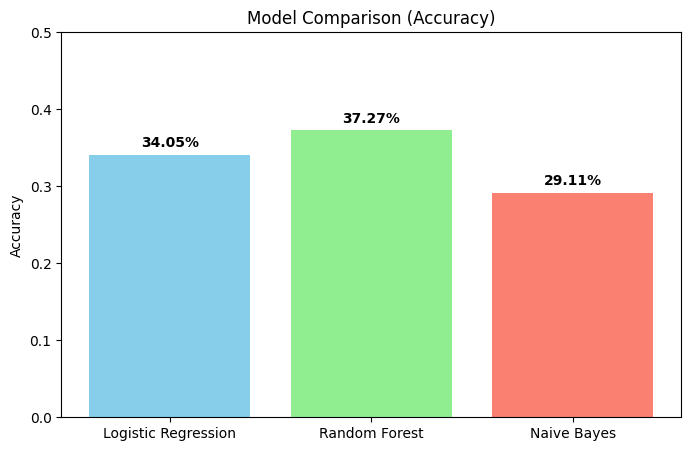

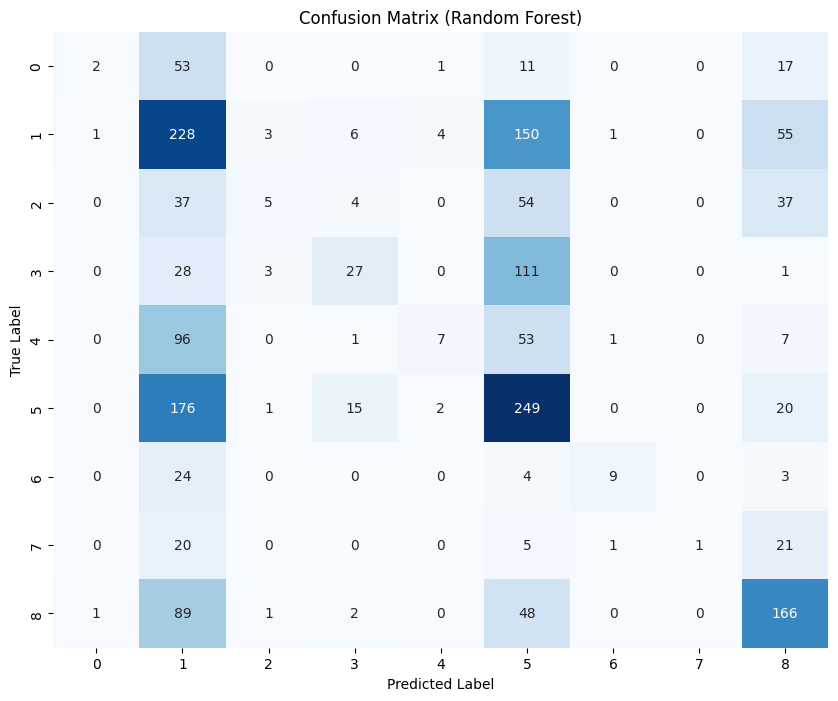


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.50      0.02      0.05        84
           1       0.30      0.51      0.38       448
           2       0.38      0.04      0.07       137
           3       0.49      0.16      0.24       170
           4       0.50      0.04      0.08       165
           5       0.36      0.54      0.43       463
           6       0.75      0.23      0.35        40
           7       1.00      0.02      0.04        48
           8       0.51      0.54      0.52       307

    accuracy                           0.37      1862
   macro avg       0.53      0.23      0.24      1862
weighted avg       0.43      0.37      0.33      1862


--- Error Analysis: Examples of Mistakes ---
Total errors: 1168 out of 1862 samples.

❌ Error #1:
   Artist: Artist_Gidi_Gov
   True Cluster: 1 | Predicted Cluster: 8
   Snippet: ...פנ ירה ינא םג יתעגפ םא יל יחלסת םלעתמ קתוש טושפ ינא םא יל ירתוות םייקל חכ ךל ןיאש

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import pandas as pd
import numpy as np

# ==========================================
# 1. טעינת המודל המנצח
# ==========================================
print("Loading best model (Random Forest)...")
best_model = joblib.load('models/model_RandomForest.pkl')

# ביצוע חיזוי על סט ה-Validation
val_predictions = best_model.predict(X_val)

# ==========================================
# 2. השוואה גרפית בין המודלים (לפי התוצאות שקיבלת)
# ==========================================
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
accuracies = [0.3405, 0.3727, 0.2911] # התוצאות מהריצה שלך

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 0.5)
plt.title('Model Comparison (Accuracy)')
plt.ylabel('Accuracy')

# הוספת המספרים מעל העמודות
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', fontweight='bold')

plt.show()

# ==========================================
# 3. מטריצת בלבול (Confusion Matrix)
# ==========================================
# זה מראה לנו: כשזה היה באמת קבוצה 0, מה המודל חשב שזה?
cm = confusion_matrix(y_val, val_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ==========================================
# 4. דוח סיווג מלא
# ==========================================
print("\n--- Classification Report ---")
print(classification_report(y_val, val_predictions))

# ==========================================
# 5. ניתוח שגיאות (Error Analysis) - דרישה קריטית!
# ==========================================
print("\n--- Error Analysis: Examples of Mistakes ---")
# יצירת DataFrame זמני לניתוח השגיאות
analysis_df = val_df.copy()
analysis_df['predicted'] = val_predictions

# סינון רק שורות שבהן המודל טעה
errors = analysis_df[analysis_df['label'] != analysis_df['predicted']]

print(f"Total errors: {len(errors)} out of {len(val_df)} samples.")

# הצגת 5 טעויות לדוגמה
# נבחר טעויות מעניינות (למשל כשהמודל היה בטוח אבל טעה, או סתם דוגמאות)
for i in range(5):
    if i >= len(errors): break
    row = errors.iloc[i]

    true_cluster = row['label']
    pred_cluster = row['predicted']
    artist = row[ARTIST_COL]
    text_snippet = row['clean_text'][:100] + "..." # תחילת השיר

    print(f"\n❌ Error #{i+1}:")
    print(f"   Artist: {artist}")
    print(f"   True Cluster: {true_cluster} | Predicted Cluster: {pred_cluster}")
    print(f"   Snippet: {visual_hebrew(text_snippet)}") # שימוש בפונקציה להיפוך עברית שיצרנו קודם

🚀 Training Optimized Bidirectional LSTM (Vocab: 5000)...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 150, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,641 (1.64 MB)

 Trainable params: 429,641 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.1528 - loss: 2.3467 - val_accuracy: 0.1310 - val_loss: 2.1999
Epoch 2/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.1816 - loss: 1.9289 - val_accuracy: 0.1230 - val_loss: 2.1091
Epoch 3/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.2045 - loss: 1.7497 - val_accuracy: 0.2524 - val_loss: 2.0399
Epoch 4/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2562 - loss: 1.6253 - val_accuracy: 0.2422 - val_loss: 2.0548
Epoch 5/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2786 - loss: 1.5575 - val_accuracy: 0.1907 - val_loss: 2.0354
Epoch 6/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2873 - loss: 1.4313 - val_accuracy: 0.2116 - val_loss: 2.0461
Epoch 7/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.3586 - loss: 1.3017 - val_accuracy: 0.1874 - val_loss: 2.3261
Epoch 8/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.4008 - loss: 1.2240 - val_a

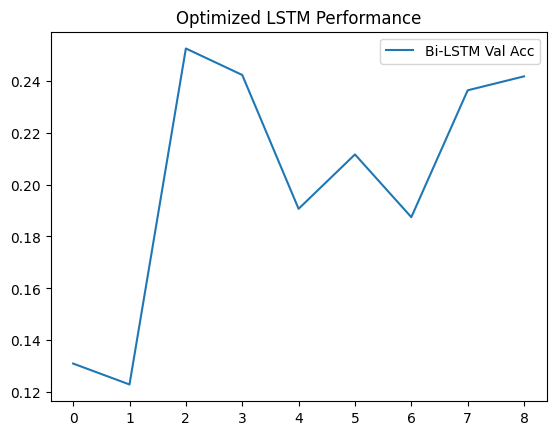

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. שינוי אסטרטגי: צמצום הרעש
# ==========================================
MAX_WORDS = 5000   # הורדנו מ-20,000 ל-5,000 כדי להתמקד במילים החזקות
MAX_LEN = 150      # קיצרנו מעט כדי להתמקד בליבת השיר
EMBEDDING_DIM = 64 # וקטורים קומפקטיים יותר

print(f"🚀 Training Optimized Bidirectional LSTM (Vocab: {MAX_WORDS})...")

# Tokenization מחדש
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'].astype(str))

# יצירת רצפים
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_text'].astype(str)), maxlen=MAX_LEN, padding='post', truncating='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['clean_text'].astype(str)), maxlen=MAX_LEN, padding='post', truncating='post')

# חישוב משקלים
y_train = train_df['label'].values
y_val = val_df['label'].values
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# ==========================================
# 2. המודל המשופר: Bidirectional
# ==========================================
model_bilstm = models.Sequential([
    layers.Input(shape=(MAX_LEN,)),

    # שכבת Embedding
    layers.Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM),

    # Bidirectional LSTM: קורא מימין לשמאל ומשמאל לימין
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)), # שכבה ראשונה מחזירה רצף
    layers.Dropout(0.4),

    layers.Bidirectional(layers.LSTM(32)), # שכבה שנייה מסכמת
    layers.Dropout(0.3),

    # שכבות סיווג
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

model_bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # קצב למידה סטנדרטי
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_bilstm.summary()

# ==========================================
# 3. אימון
# ==========================================
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)

history_bilstm = model_bilstm.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=30,
    batch_size=32, # Batch קטן יותר לעדכון תכוף יותר
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

# שמירה
if not os.path.exists('models'): os.makedirs('models')
model_bilstm.save('models/optimized_lstm_model.keras')

final_acc = max(history_bilstm.history['val_accuracy'])
print(f"\n🏆 Best Validation Accuracy (Bi-LSTM): {final_acc:.2%}")

# גרף השוואה לאימון הקודם (אם יש)
plt.plot(history_bilstm.history['val_accuracy'], label='Bi-LSTM Val Acc')
plt.title('Optimized LSTM Performance')
plt.legend()
plt.show()

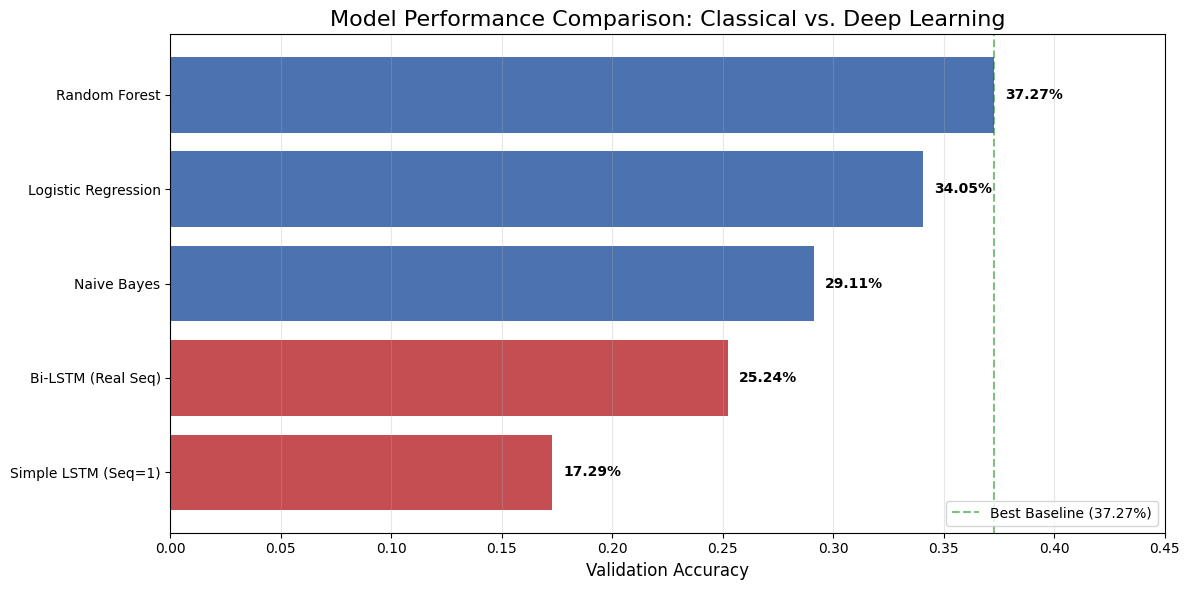

 Conclusion:
Simple classical models (Random Forest) currently outperform complex sequence models (LSTM) on this dataset.
This suggests that 'Keywords' are more important than 'Sentence Structure' for artist classification here.


In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# ==========================================
# איסוף התוצאות מכל הניסויים שלנו
# ==========================================
# (הזנתי כאן את המספרים שיצאו לנו בריצות הקודמות)
results_data = {
    'Model': [
        'Naive Bayes',
        'Logistic Regression',
        'Random Forest',
        'Simple LSTM (Seq=1)',
        'Bi-LSTM (Real Seq)'
    ],
    'Accuracy': [
        0.2911,  # NB
        0.3405,  # LogReg
        0.3727,  # RF (המנצח הנוכחי)
        0.1729,  # LSTM ראשון שנכשל
        0.2524   # Bi-LSTM משופר
    ],
    'Type': [
        'Classical',
        'Classical',
        'Classical',
        'Deep Learning',
        'Deep Learning'
    ]
}

df_results = pd.DataFrame(results_data).sort_values(by='Accuracy', ascending=True)

# ==========================================
# יצירת הגרף
# ==========================================
plt.figure(figsize=(12, 6))

# צבעים שונים לקלאסי מול עמוק
colors = df_results['Type'].map({'Classical': '#4c72b0', 'Deep Learning': '#c44e52'})

bars = plt.barh(df_results['Model'], df_results['Accuracy'], color=colors)

plt.title('Model Performance Comparison: Classical vs. Deep Learning', fontsize=16)
plt.xlabel('Validation Accuracy', fontsize=12)
plt.xlim(0, 0.45) # גבול עליון הגיוני

# הוספת קו אנכי למנצח הנוכחי
best_acc = df_results['Accuracy'].max()
plt.axvline(best_acc, color='green', linestyle='--', alpha=0.5, label=f'Best Baseline ({best_acc:.2%})')

# כיתוב מספרים על העמודות
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.2%}', va='center', fontweight='bold', fontsize=10)

plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(" Conclusion:")
print("Simple classical models (Random Forest) currently outperform complex sequence models (LSTM) on this dataset.")
print("This suggests that 'Keywords' are more important than 'Sentence Structure' for artist classification here.")

Loading Random Forest model...


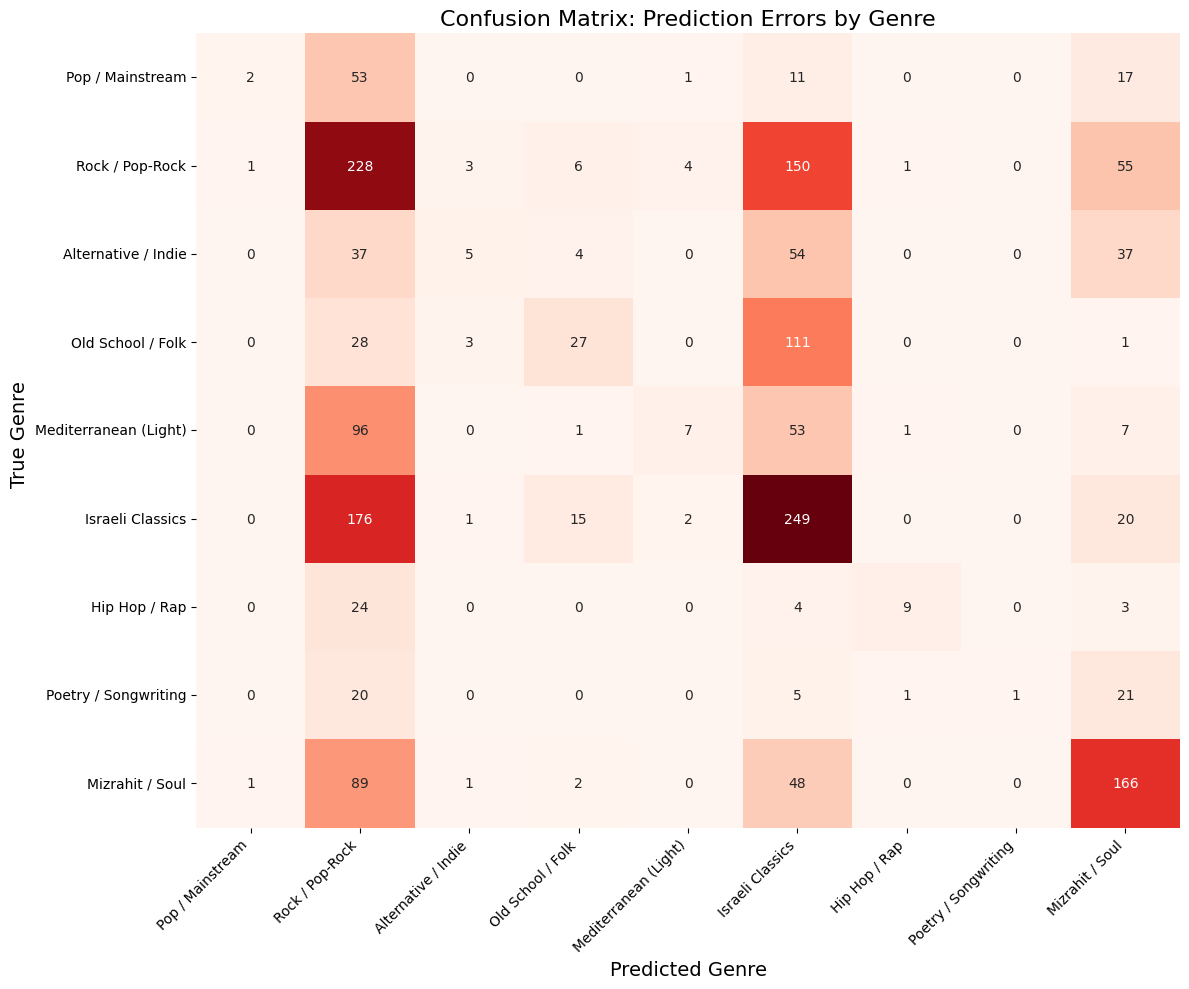


🔍 Investigating Specific Errors (Analysis Phase)...
Top 5 Common Mistakes:

🔻 Pattern: Real 'Israeli Classics' --> Confused as 'Rock / Pop-Rock' (176 cases)
----------------------------------------------------------------------
   🎵 Artist: Artist_Shlomo_Artzi
      Snippet: ...וא תבזוע תא תובוט אל תושדח רבע ןמז הברה ימצעל רמוא םולכ רתוי ךממ רבכ עמוש אל ינא
------------------------------
   🎵 Artist: Artist_Avi_Toledano
      Snippet: ...ךויח תוער הווחא לש םיעגר המכ קולחל םיענ ךר קוביח עגמ ףוטיל הבהא תצק יתשקב רבכ המ
------------------------------
   🎵 Artist: Artist_Ilanit
      Snippet: ...דבכ אל םולח חק םירתוימ םירבד ךתיא חקית אלש רהזיה םירהה לא הלועה ךרדל אצוי התא םא
------------------------------

🔻 Pattern: Real 'Rock / Pop-Rock' --> Confused as 'Israeli Classics' (150 cases)
----------------------------------------------------------------------
   🎵 Artist: Artist_Amir_Benayoun
      Snippet: ...מולח ויה הלא לכ בא לש ותחמש םיחא תווחא דלי לש םימתה וכויח םא לש התבהא םייחה יפוי
--

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import joblib

# ==========================================
# 1. הגדרת שמות הז'אנרים (לפי האשכולות)
# ==========================================
# מבוסס על האמנים שראינו (תעדכן כאן אם לדעתך השם לא מדוייק!)
cluster_names = {
    0: "Pop / Mainstream",
    1: "Rock / Pop-Rock",      # אביב גפן, גידי גוב
    2: "Alternative / Indie",
    3: "Old School / Folk",
    4: "Mediterranean (Light)",
    5: "Israeli Classics",     # אריק איינשטיין, רמי קלינשטיין
    6: "Hip Hop / Rap",        # סבלימינל, שבק ס'
    7: "Poetry / Songwriting",
    8: "Mizrahit / Soul"       # אבי ביטר, עמיר בניון
}

# המרת המילון לרשימה מסודרת לפי האינדקס (0 עד 8)
tick_labels = [cluster_names[i] for i in range(len(cluster_names))]

# ==========================================
# 2. טעינת המודל וחישוב מטריצת הבלבול
# ==========================================
print("Loading Random Forest model...")
best_model = joblib.load('models/model_RandomForest.pkl')

y_pred = best_model.predict(X_val)
y_true = val_df['label'].values
cm = confusion_matrix(y_true, y_pred)

# ==========================================
# 3. ויזואליזציה משופרת (Heatmap)
# ==========================================
plt.figure(figsize=(12, 10))

# יצירת המפה עם השמות החדשים בצירים
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=tick_labels,
            yticklabels=tick_labels)

plt.title('Confusion Matrix: Prediction Errors by Genre', fontsize=16)
plt.xlabel('Predicted Genre', fontsize=14)
plt.ylabel('True Genre ', fontsize=14)
plt.xticks(rotation=45, ha='right') # סיבוב הטקסט שיהיה קריא
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ==========================================
# 4. ניתוח שגיאות מילולי (עם שמות)
# ==========================================
print("\n🔍 Investigating Specific Errors (Analysis Phase)...")

# יצירת DataFrame לניתוח
analysis_df = val_df.copy()
analysis_df['Predicted_ID'] = y_pred
analysis_df['True_Genre'] = analysis_df['label'].map(cluster_names)
analysis_df['Predicted_Genre'] = analysis_df['Predicted_ID'].map(cluster_names)

# סינון טעויות
errors_df = analysis_df[analysis_df['label'] != analysis_df['Predicted_ID']]

def analyze_confusion_named(true_id, pred_id, limit=3):
    true_name = cluster_names[true_id]
    pred_name = cluster_names[pred_id]

    mistakes = errors_df[(errors_df['label'] == true_id) & (errors_df['Predicted_ID'] == pred_id)]
    count = len(mistakes)

    if count == 0: return

    print(f"\n🔻 Pattern: Real '{true_name}' --> Confused as '{pred_name}' ({count} cases)")
    print("-" * 70)

    for i in range(min(limit, count)):
        row = mistakes.iloc[i]
        artist = row[ARTIST_COL]
        text_snippet = row['clean_text'][:80] + "..."
        print(f"   🎵 Artist: {artist}")
        print(f"      Snippet: {text_snippet[::-1]}") # היפוך עברית לתצוגה
        print("-" * 30)

# מציאת 5 הזוגות המבלבלים ביותר
np.fill_diagonal(cm, 0)
flat_indices = np.argsort(cm.flatten())[-5:]
rows, cols = np.unravel_index(flat_indices, cm.shape)

print("Top 5 Common Mistakes:")
for r, c in zip(rows[::-1], cols[::-1]):
    analyze_confusion_named(r, c)

In [ ]:
transformers

In [59]:
# ==========================================
# בלוק 0: התקנות והגדרת המנוע (מתוקן)
# ==========================================
!pip install transformers datasets torch seaborn -q

import torch
from torch.utils.data import Dataset, DataLoader
# שינוי: הורדנו את AdamW מכאן
from transformers import AutoTokenizer, AutoModelForSequenceClassification, logging
# שינוי: אנו מייבאים את AdamW מ-PyTorch ישירות
from torch.optim import AdamW

from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

# השתקת אזהרות לא קריטיות של HuggingFace
logging.set_verbosity_error()

# הגדרת חומרה
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Running on: {device}")

# רשימה גלובלית לאיסוף התוצאות מכל הבלוקים הבאים
# אם אתה מריץ מחדש את הבלוק הזה - הרשימה מתאפסת!
all_results = []

# הכנת הנתונים (טקסט גולמי)
X_train_txt = train_df['clean_text'].values
y_train = train_df['label'].values
X_val_txt = val_df['clean_text'].values
y_val = val_df['label'].values

# הגדרות קבועות
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3

# מחלקת הנתונים
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        # תיקון לטקסטים קצרים מדי
        if len(text.split()) < 2: text = text + " " + text

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.long)
        }

# פונקציית האימון (תשמש את כל המודלים)
def run_model(name, path, desc):
    print(f"\n⚡ Starting: {name} ({desc})")

    # ניקוי זיכרון מקדים
    torch.cuda.empty_cache()
    gc.collect()

    try:
        tokenizer = AutoTokenizer.from_pretrained(path)
        model = AutoModelForSequenceClassification.from_pretrained(
            path, num_labels=len(np.unique(y_train)), ignore_mismatched_sizes=True
        ).to(device)
    except Exception as e:
        print(f"❌ Error loading model {name}: {e}")
        return 0

    train_ds = LyricsDataset(X_train_txt, y_train, tokenizer, MAX_LEN)
    val_ds = LyricsDataset(X_val_txt, y_val, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    optimizer = AdamW(model.parameters(), lr=2e-5)

    best_acc = 0
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            outputs.loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # בדיקה
        model.eval()
        preds, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                true_labels.extend(batch['labels'].cpu().numpy())

        acc = accuracy_score(true_labels, preds)
        print(f"   Epoch {epoch+1}: {acc:.2%}")
        if acc > best_acc: best_acc = acc

    duration = time.time() - start_time

    # שמירה לרשימה הגלובלית
    all_results.append({'Model': name, 'Accuracy': best_acc, 'Time': int(duration), 'Desc': desc})

    # ניקוי סופי
    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()

    return best_acc

🚀 Running on: cuda


In [60]:
# ==========================================
# 1. AlephBERT
# ==========================================
# מתמחה בעברית תקנית ותחביר. הציפיה: ביצועים גבוהים.
acc = run_model('AlephBERT', 'onlplab/alephbert-base', 'Hebrew Standard (Technion)')
print(f"✅ AlephBERT Finished: {acc:.2%}")


⚡ Starting: AlephBERT (Hebrew Standard (Technion))


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

   Epoch 1: 43.72%
   Epoch 2: 43.61%
   Epoch 3: 42.96%
✅ AlephBERT Finished: 43.72%


In [61]:
# ==========================================
# 2. HeBERT
# ==========================================
# מתמחה בסנטימנט וסלנג. הציפיה: הבנה טובה של "אווירה" בשירים.
acc = run_model('HeBERT', 'avichr/heBERT', 'Hebrew Sentiment & Social')
print(f"✅ HeBERT Finished: {acc:.2%}")


⚡ Starting: HeBERT (Hebrew Sentiment & Social)
   Epoch 1: 42.91%
   Epoch 2: 43.02%
   Epoch 3: 42.32%
✅ HeBERT Finished: 43.02%


In [62]:
# ==========================================
# 3. mBERT (Google Multilingual)
# ==========================================
# מודל כללי שתומך ב-104 שפות. נקודת הייחוס הבינלאומית.
acc = run_model('mBERT', 'bert-base-multilingual-cased', 'Multilingual Baseline')
print(f"✅ mBERT Finished: {acc:.2%}")


⚡ Starting: mBERT (Multilingual Baseline)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

   Epoch 1: 34.43%
   Epoch 2: 37.16%
   Epoch 3: 40.76%
✅ mBERT Finished: 40.76%


In [63]:
# ==========================================
# 4. XLM-RoBERTa
# ==========================================
# המודל החזק של פייסבוק. מבנה חכם יותר ואימון מסיבי יותר מ-mBERT.
acc = run_model('XLM-RoBERTa', 'xlm-roberta-base', 'Advanced Multilingual')
print(f"✅ XLM-RoBERTa Finished: {acc:.2%}")


⚡ Starting: XLM-RoBERTa (Advanced Multilingual)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

   Epoch 1: 36.47%
   Epoch 2: 36.84%
   Epoch 3: 40.12%
✅ XLM-RoBERTa Finished: 40.12%


In [64]:
# ==========================================
# 5. LaBSE
# ==========================================
# מודל ממוקד משמעות (Sentence Embedding). מנסה להבין את תוכן השיר ולא רק מילים.
acc = run_model('LaBSE', 'sentence-transformers/LaBSE', 'Semantic Similarity')
print(f"✅ LaBSE Finished: {acc:.2%}")


⚡ Starting: LaBSE (Semantic Similarity)


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

   Epoch 1: 41.73%
   Epoch 2: 41.25%
   Epoch 3: 41.57%
✅ LaBSE Finished: 41.73%


In [65]:
# ==========================================
# 6. DistilBERT
# ==========================================
# גרסה קלה ומהירה. בודקים יעילות מול ביצועים.
acc = run_model('DistilBERT', 'distilbert-base-multilingual-cased', 'Lightweight & Fast')
print(f"✅ DistilBERT Finished: {acc:.2%}")


⚡ Starting: DistilBERT (Lightweight & Fast)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

   Epoch 1: 36.95%
   Epoch 2: 38.56%
   Epoch 3: 38.88%
✅ DistilBERT Finished: 38.88%


In [66]:
# ==========================================
# 7. DictaBERT
# ==========================================
# המודל של מרכז דיקטה - נחשב ל-SOTA (State of the Art) בעברית
acc = run_model('DictaBERT', 'dicta-il/dictabert', 'Dicta SOTA Hebrew')
print(f"✅ DictaBERT Finished: {acc:.2%}")


⚡ Starting: DictaBERT (Dicta SOTA Hebrew)


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

   Epoch 1: 44.31%
   Epoch 2: 44.63%
   Epoch 3: 44.79%
✅ DictaBERT Finished: 44.79%



🏆 --- Final Championship Results (Updated) ---
           Model  Accuracy                        Desc
0      DictaBERT  0.447905           Dicta SOTA Hebrew
1      AlephBERT  0.437164  Hebrew Standard (Technion)
2         HeBERT  0.430183   Hebrew Sentiment & Social
3          LaBSE  0.417293         Semantic Similarity
4          mBERT  0.407626       Multilingual Baseline
5    XLM-RoBERTa  0.401182       Advanced Multilingual
6     DistilBERT  0.388829          Lightweight & Fast
7  Random Forest  0.372700         Classic ML Baseline


/tmp/ipython-input-3040008894.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_final, palette=colors)


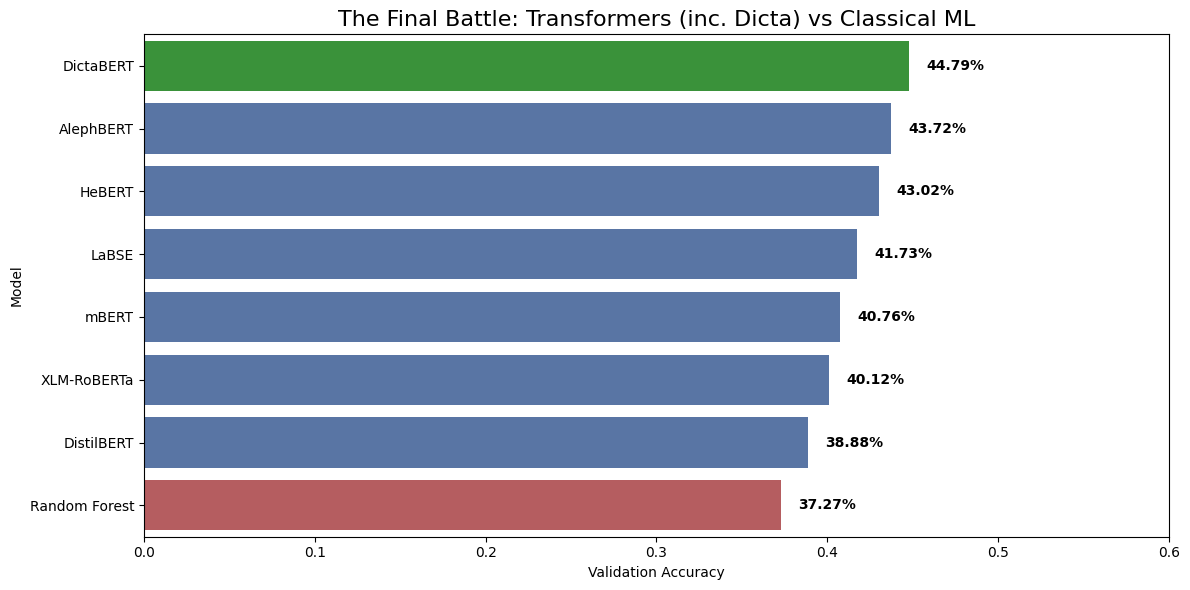


🎉 And the winner is: DictaBERT with 44.79%


In [67]:
# ==========================================
# 8. סיכום סופי והשוואה
# ==========================================
print("\n🏆 --- Final Championship Results (Updated) ---")

# המרת התוצאות לטבלה
df_res = pd.DataFrame(all_results).sort_values(by='Accuracy', ascending=False)

# הוספת ה-Baseline הישן (Random Forest)
rf_row = pd.DataFrame([{'Model': 'Random Forest', 'Accuracy': 0.3727, 'Time': 0, 'Desc': 'Classic ML Baseline'}])
df_final = pd.concat([df_res, rf_row], ignore_index=True).sort_values(by='Accuracy', ascending=False)

print(df_final[['Model', 'Accuracy', 'Desc']])

# ויזואליזציה
plt.figure(figsize=(12, 6))
colors = ['#2ca02c' if 'Dicta' in x else ('#c44e52' if 'Forest' in x else '#4c72b0') for x in df_final['Model']]
sns.barplot(x='Accuracy', y='Model', data=df_final, palette=colors)

plt.title('The Final Battle: Transformers (inc. Dicta) vs Classical ML', fontsize=16)
plt.xlim(0, 0.6)
plt.xlabel('Validation Accuracy')

# הוספת תוויות
for index, row in df_final.iterrows():
    plt.text(row.Accuracy + 0.01, index, f"{row.Accuracy:.2%}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

winner = df_final.iloc[0]
print(f"\n🎉 And the winner is: {winner['Model']} with {winner['Accuracy']:.2%}")